# Problem 2: Incorporating CNNs

* Learning Objective: In this problem, you will learn how to deeply understand how Convolutional Neural Networks work by implementing one.
* Provided Code: We provide the skeletons of classes you need to complete. Forward checking and gradient checkings are provided for verifying your implementation as well.
* TODOs: you will implement a Convolutional Layer and a MaxPooling Layer to improve on your classification results in part 1.

In [1]:
from lib.mlp.fully_conn import *
from lib.mlp.layer_utils import *
from lib.mlp.train import *
from lib.cnn.layer_utils import *
from lib.cnn.cnn_models import *
from lib.datasets import *
from lib.grad_check import *
from lib.optim import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading the data (CIFAR-100 with 20 superclasses)

In this homework, we will be classifying images from the CIFAR-100 dataset into the 20 superclasses. More information about the CIFAR-100 dataset and the 20 superclasses can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

Download the CIFAR-100 data files [here](https://drive.google.com/drive/folders/1imXxTnpkMbWEe41pkAGNt_JMTXECDSaW?usp=share_link), and save the `.mat` files to the `data/cifar100` directory.

In [2]:
data = CIFAR100_data('data/cifar100/')
for k, v in data.items():
    if type(v) == np.ndarray:
        print ("Name: {} Shape: {}, {}".format(k, v.shape, type(v)))
    else:
        print("{}: {}".format(k, v))
label_names = data['label_names']
mean_image = data['mean_image'][0]
std_image = data['std_image'][0]

Name: data_train Shape: (40000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_train Shape: (40000,), <class 'numpy.ndarray'>
Name: data_val Shape: (10000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_val Shape: (10000,), <class 'numpy.ndarray'>
Name: data_test Shape: (10000, 32, 32, 3), <class 'numpy.ndarray'>
Name: labels_test Shape: (10000,), <class 'numpy.ndarray'>
label_names: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
Name: mean_image Shape: (1, 1, 1, 3), <class 'numpy.ndarray'>
Name: std_image Shape: (1, 1, 1, 3), <class 'numpy.ndarray'>


Label: large_omnivores_and_herbivores


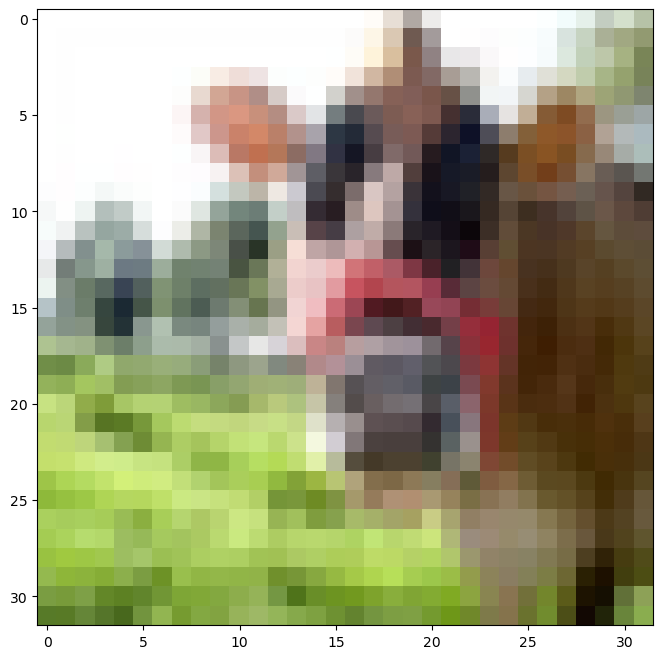

In [3]:
idx = 0
image_data = data['data_train'][idx]
image_data = ((image_data*std_image + mean_image) * 255).astype(np.int32)
plt.imshow(image_data)
label = label_names[data['labels_train'][idx]]
print("Label:", label)

## Convolutional Neural Networks

We will use convolutional neural networks to try to improve on the results from Problem 1. Convolutional layers make the assumption that local pixels are more important for prediction than far-away pixels. This allows us to form networks that are robust to small changes in positioning in images.

### Convolutional Layer Output size calculation [2pts]

As you have learned, two important parameters of a convolutional layer are its stride and padding. To warm up, we will need to calculate the output size of a convolutional layer given its stride and padding. To do this, open the `lib/cnn/layer_utils.py` file and fill out the TODO section in the `get_output_size` function in the ConvLayer2D class. 

Implement your function so that it returns the correct size as indicated by the block below.

In [4]:
%reload_ext autoreload

input_image = np.zeros([32, 28, 28, 3]) # a stack of 32 28 by 28 rgb images

in_channels = input_image.shape[-1] #must agree with the last dimension of the input image
k_size = 4 
n_filt = 16

conv_layer = ConvLayer2D(in_channels, k_size, n_filt, stride=2, padding=3)
output_size = conv_layer.get_output_size(input_image.shape) 

print("Received {} and expected [32, 16, 16, 16]".format(output_size))

Received [32, 16, 16, 16] and expected [32, 16, 16, 16]


### Convolutional Layer Forward Pass [5pts]

Now, we will implement the forward pass of a convolutional layer. Fill in the TODO block in the `forward` function of the ConvLayer2D class.

In [16]:
%reload_ext autoreload

# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=1*8*8*1).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image
in_channels, k_size, n_filt = 1, 5, 2

weight_size = k_size*k_size*in_channels*n_filt
bias_size = n_filt



single_conv = ConvLayer2D(in_channels, k_size, n_filt, stride=1, padding=0, name="conv_test")

w = np.linspace(-0.2, 0.2, num=weight_size).reshape(k_size, k_size, in_channels, n_filt)
b = np.linspace(-0.3, 0.3, num=bias_size)

single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b

out = single_conv.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 4, 4, 2)".format(out.shape))

correct_out = np.array([[
   [[-0.03874312, 0.57000324],
   [-0.03955296, 0.57081309],
   [-0.04036281, 0.57162293],
   [-0.04117266, 0.57243278]],

  [[-0.0452219, 0.57648202],
   [-0.04603175, 0.57729187],
   [-0.04684159, 0.57810172],
   [-0.04765144, 0.57891156]],

  [[-0.05170068, 0.5829608 ],
   [-0.05251053, 0.58377065],
   [-0.05332038, 0.5845805 ],
   [-0.05413022, 0.58539035]],

  [[-0.05817946, 0.58943959],
   [-0.05898931, 0.59024943],
   [-0.05979916, 0.59105928],
   [-0.06060901, 0.59186913]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-7
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 4, 4, 2), Expected output shape: (1, 4, 4, 2)
Difference:  5.110565335399418e-08


### Conv Layer Backward [5pts]

Now complete the backward pass of a convolutional layer. Fill in the TODO block in the `backward` function of the ConvLayer2D class. Check you results with this code and expect differences of less than 1e-6.

In [36]:
%reload_ext autoreload

# Test the conv backward function
img = np.random.randn(15, 8, 8, 3)
w = np.random.randn(4, 4, 3, 12)
b = np.random.randn(12)
dout = np.random.randn(15, 4, 4, 12)

single_conv = ConvLayer2D(input_channels=3, kernel_size=4, number_filters=12, stride=2, padding=1, name="conv_test")
single_conv.params[single_conv.w_name] = w
single_conv.params[single_conv.b_name] = b

dimg_num = eval_numerical_gradient_array(lambda x: single_conv.forward(img), img, dout)
dw_num = eval_numerical_gradient_array(lambda w: single_conv.forward(img), w, dout)
db_num = eval_numerical_gradient_array(lambda b: single_conv.forward(img), b, dout)

out = single_conv.forward(img)

dimg = single_conv.backward(dout)
dw = single_conv.grads[single_conv.w_name]
db = single_conv.grads[single_conv.b_name]

# The error should be around 1e-6
print("dimg Error: ", rel_error(dimg_num, dimg))
# The errors should be around 1e-8
print("dw Error: ", rel_error(dw_num, dw))
print("db Error: ", rel_error(db_num, db))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  1.3373315615195266e-08
dw Error:  3.5941090147009086e-08
db Error:  1.1373030799235595e-10
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


## Max pooling Layer
Now we will implement maxpooling layers, which can help to reduce the image size while preserving the overall structure of the image.

### Forward Pass max pooling [5pts]
Fill out the TODO block in the `forward` function of the MaxPoolingLayer class.

In [42]:
# Test the convolutional forward function
input_image = np.linspace(-0.1, 0.4, num=64).reshape([1, 8, 8, 1]) # a single 8 by 8 grayscale image

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")
out = maxpool.forward(input_image)

print("Received output shape: {}, Expected output shape: (1, 3, 3, 1)".format(out.shape))

correct_out = np.array([[
   [[0.11428571],
   [0.13015873],
   [0.14603175]],

  [[0.24126984],
   [0.25714286],
   [0.27301587]],

  [[0.36825397],
   [0.38412698],
   [0.4       ]]]])

# Compare your output with the above pre-computed ones. 
# The difference should not be larger than 1e-7
print ("Difference: ", rel_error(out, correct_out))

Received output shape: (1, 3, 3, 1), Expected output shape: (1, 3, 3, 1)
Difference:  1.8750000280978013e-08


### Backward Pass Max pooling [5pts]
Fill out the `backward` function in the MaxPoolingLayer class.

In [44]:
img = np.random.randn(15, 8, 8, 3)

dout = np.random.randn(15, 3, 3, 3)

maxpool= MaxPoolingLayer(pool_size=4, stride=2, name="maxpool_test")

dimg_num = eval_numerical_gradient_array(lambda x: maxpool.forward(img), img, dout)

out = maxpool.forward(img)
dimg = maxpool.backward(dout)

# The error should be around 1e-8
print("dimg Error: ", rel_error(dimg_num, dimg))
# The shapes should be same
print("dimg Shape: ", dimg.shape, img.shape)

dimg Error:  3.2759412891000115e-12
dimg Shape:  (15, 8, 8, 3) (15, 8, 8, 3)


### Test a Small Convolutional Neural Network [3pts]
Please find the `TestCNN` class in `lib/cnn/cnn_models.py`.
Again you only need to complete few lines of code in the TODO block.
Please design a Convolutional --> Maxpool --> flatten --> fc network where the shapes of parameters match the given shapes.
Please insert the corresponding names you defined for each layer to param_name_w, and param_name_b respectively.
Here you only modify the param_name part, the _w, and _b are automatically assigned during network setup.

In [49]:
%reload_ext autoreload

seed = 1234
np.random.seed(seed=seed)

model = TestCNN()
loss_func = cross_entropy()

B, H, W, iC = 4, 8, 8, 3 #batch, height, width, in_channels
k = 3 #kernel size
oC, Hi, O = 3, 27, 5 # out channels, Hidden Layer input, Output size
std = 0.02
x = np.random.randn(B,H,W,iC)
y = np.random.randint(O, size=B)

print ("Testing initialization ... ")

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
w1_std = abs(model.net.get_params("convolution1_w").std() - std)
b1 = model.net.get_params("convolution1_b").std()
w2_std = abs(model.net.get_params("fully1_w").std() - std)
b2 = model.net.get_params("fully1_b").std()
###################################################
#                END OF YOUR CODE                 #
###################################################

assert w1_std < std / 10, "First layer weights do not seem right"
assert np.all(b1 == 0), "First layer biases do not seem right"
assert w2_std < std / 10, "Second layer weights do not seem right"
assert np.all(b2 == 0), "Second layer biases do not seem right"
print ("Passed!")

print ("Testing test-time forward pass ... ")
w1 = np.linspace(-0.7, 0.3, num=k*k*iC*oC).reshape(k,k,iC,oC)
w2 = np.linspace(-0.2, 0.2, num=Hi*O).reshape(Hi, O)
b1 = np.linspace(-0.6, 0.2, num=oC)
b2 = np.linspace(-0.9, 0.1, num=O)

###################################################
# TODO: param_name should be replaced accordingly  #
###################################################
model.net.assign("convolution1_w", w1)
model.net.assign("convolution1_b", b1)
model.net.assign("fully1_w", w2)
model.net.assign("fully1_b", b2)
###################################################
#                END OF YOUR CODE                 #
###################################################

feats = np.linspace(-5.5, 4.5, num=B*H*W*iC).reshape(B,H,W,iC)
scores = model.forward(feats)
correct_scores = np.asarray([[-13.85107294, -11.52845818,  -9.20584342,  -6.88322866,  -4.5606139 ],
 [-11.44514171, -10.21200524 , -8.97886878 , -7.74573231 , -6.51259584],
 [ -9.03921048,  -8.89555231 , -8.75189413 , -8.60823596,  -8.46457778],
 [ -6.63327925 , -7.57909937 , -8.52491949 , -9.4707396 , -10.41655972]])
scores_diff = np.sum(np.abs(scores - correct_scores))
assert scores_diff < 1e-6, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the loss ...",)
y = np.asarray([0, 2, 1, 4])
loss = loss_func.forward(scores, y)
dLoss = loss_func.backward()
correct_loss = 4.56046848799693
assert abs(loss - correct_loss) < 1e-10, "Your implementation might be wrong!"
print ("Passed!")

print ("Testing the gradients (error should be no larger than 1e-6) ...")
din = model.backward(dLoss)
for layer in model.net.layers:
    if not layer.params:
        continue
    for name in sorted(layer.grads):
        f = lambda _: loss_func.forward(model.forward(feats), y)
        grad_num = eval_numerical_gradient(f, layer.params[name], verbose=False)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, layer.grads[name])))

Testing initialization ... 
Passed!
Testing test-time forward pass ... 
Passed!
Testing the loss ...
Passed!
Testing the gradients (error should be no larger than 1e-6) ...
convolution1_b relative error: 2.97e-09
convolution1_w relative error: 1.06e-09
fully1_b relative error: 9.76e-11
fully1_w relative error: 3.89e-07


### Training the Network [25pts]
In this section, we defined a `SmallConvolutionalNetwork` class for you to fill in the TODO block in `lib/cnn/cnn_models.py`.

Here please design a network with at most two convolutions and two maxpooling layers (you may use less).
You can adjust the parameters for any layer, and include layers other than those listed above that you have implemented (such as fully-connected layers and non-linearities).
You are also free to select any optimizer you have implemented (with any learning rate).

You will train your network on CIFAR-100 20-way superclass classification.
Try to find a combination that is able to achieve 40% validation accuracy.

Since the CNN takes significantly longer to train than the fully connected network, it is suggested to start off with fewer filters in your Conv layers and fewer intermediate fully-connected layers so as to get faster initial results.

In [50]:
# Arrange the data
data_dict = {
    "data_train": (data["data_train"], data["labels_train"]),
    "data_val": (data["data_val"], data["labels_val"]),
    "data_test": (data["data_test"], data["labels_test"])
}

In [51]:
print("Data shape:", data_dict["data_train"][0].shape)
print("Flattened data input size:", np.prod(data["data_train"].shape[1:]))
print("Number of data classes:", max(data['labels_train']) + 1)

Data shape: (40000, 32, 32, 3)
Flattened data input size: 3072
Number of data classes: 20


In [66]:
%reload_ext autoreload

seed = 123
np.random.seed(seed=seed)

model = SmallConvolutionalNetwork()
loss_f = cross_entropy()


results = None
#############################################################################
# TODO: Use the train_net function you completed to train a network         #
# You may only adjust the hyperparameters within this block                 #
#############################################################################
optimizer = Adam(model.net, 1e-3)

batch_size = 64
epochs = 8
lr_decay = .8
lr_decay_every = 100
regularization = "none"
reg_lambda = 0.01
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
results = train_net(data_dict, model, loss_f, optimizer, batch_size, epochs, 
                    lr_decay, lr_decay_every, show_every=100, verbose=True, regularization=regularization, reg_lambda=reg_lambda)
opt_params, loss_hist, train_acc_hist, val_acc_hist = results

  0%|          | 1/625 [00:00<10:06,  1.03it/s]

(Iteration 1 / 5000) Average loss: 2.9960088597242747


 16%|█▌        | 101/625 [01:29<07:47,  1.12it/s]

(Iteration 101 / 5000) Average loss: 2.649139163067661


 32%|███▏      | 201/625 [02:58<06:15,  1.13it/s]

(Iteration 201 / 5000) Average loss: 2.3890945352771342


 48%|████▊     | 301/625 [04:28<04:48,  1.12it/s]

(Iteration 301 / 5000) Average loss: 2.225921320044827


 64%|██████▍   | 401/625 [05:57<03:19,  1.12it/s]

(Iteration 401 / 5000) Average loss: 2.116756800775336


 80%|████████  | 501/625 [07:25<01:49,  1.13it/s]

(Iteration 501 / 5000) Average loss: 1.9814988419529158


 96%|█████████▌| 601/625 [08:54<00:21,  1.12it/s]

(Iteration 601 / 5000) Average loss: 1.9679583924902215


100%|██████████| 625/625 [09:16<00:00,  1.12it/s]


(Epoch 1 / 8) Training Accuracy: 0.44785, Validation Accuracy: 0.4094


 12%|█▏        | 76/625 [01:07<08:10,  1.12it/s]

(Iteration 701 / 5000) Average loss: 1.8020024141648456


 28%|██▊       | 176/625 [02:37<06:41,  1.12it/s]

(Iteration 801 / 5000) Average loss: 1.7126840730180422


 44%|████▍     | 276/625 [04:06<05:09,  1.13it/s]

(Iteration 901 / 5000) Average loss: 1.6689677563371306


 60%|██████    | 376/625 [05:35<03:43,  1.11it/s]

(Iteration 1001 / 5000) Average loss: 1.6532706516876337


 76%|███████▌  | 476/625 [07:05<02:11,  1.13it/s]

(Iteration 1101 / 5000) Average loss: 1.6334971372311216


 92%|█████████▏| 576/625 [08:34<00:43,  1.13it/s]

(Iteration 1201 / 5000) Average loss: 1.609036270050188


100%|██████████| 625/625 [09:17<00:00,  1.12it/s]


(Epoch 2 / 8) Training Accuracy: 0.599825, Validation Accuracy: 0.469


  8%|▊         | 51/625 [00:45<08:31,  1.12it/s]

(Iteration 1301 / 5000) Average loss: 1.437287946356658


 24%|██▍       | 151/625 [02:15<07:03,  1.12it/s]

(Iteration 1401 / 5000) Average loss: 1.268680092623291


 40%|████      | 251/625 [03:45<05:36,  1.11it/s]

(Iteration 1501 / 5000) Average loss: 1.2255629917499238


 56%|█████▌    | 351/625 [05:15<04:05,  1.11it/s]

(Iteration 1601 / 5000) Average loss: 1.2601154520994549


 72%|███████▏  | 451/625 [06:45<02:35,  1.12it/s]

(Iteration 1701 / 5000) Average loss: 1.214675637896135


 88%|████████▊ | 551/625 [08:15<01:06,  1.11it/s]

(Iteration 1801 / 5000) Average loss: 1.2368770951163748


100%|██████████| 625/625 [09:21<00:00,  1.11it/s]


(Epoch 3 / 8) Training Accuracy: 0.771625, Validation Accuracy: 0.5072


  4%|▍         | 26/625 [00:23<09:00,  1.11it/s]

(Iteration 1901 / 5000) Average loss: 1.1289184138059851


 20%|██        | 126/625 [01:53<07:29,  1.11it/s]

(Iteration 2001 / 5000) Average loss: 0.7570876003718291


 36%|███▌      | 226/625 [03:23<05:58,  1.11it/s]

(Iteration 2101 / 5000) Average loss: 0.7587647019773048


 52%|█████▏    | 326/625 [04:54<04:29,  1.11it/s]

(Iteration 2201 / 5000) Average loss: 0.7929031560795753


 68%|██████▊   | 426/625 [06:23<02:58,  1.11it/s]

(Iteration 2301 / 5000) Average loss: 0.8159137895567602


 84%|████████▍ | 526/625 [07:53<01:29,  1.11it/s]

(Iteration 2401 / 5000) Average loss: 0.8000649634239251


100%|██████████| 625/625 [09:23<00:00,  1.11it/s]


(Epoch 4 / 8) Training Accuracy: 0.9024, Validation Accuracy: 0.5023


  0%|          | 1/625 [00:00<09:21,  1.11it/s]

(Iteration 2501 / 5000) Average loss: 0.8088394724027899


 16%|█▌        | 101/625 [01:31<07:51,  1.11it/s]

(Iteration 2601 / 5000) Average loss: 0.3566490216056357


 32%|███▏      | 201/625 [03:01<06:21,  1.11it/s]

(Iteration 2701 / 5000) Average loss: 0.33580814817072907


 48%|████▊     | 301/625 [04:31<04:51,  1.11it/s]

(Iteration 2801 / 5000) Average loss: 0.36444406774417915


 64%|██████▍   | 401/625 [06:01<03:21,  1.11it/s]

(Iteration 2901 / 5000) Average loss: 0.39766554604590887


 80%|████████  | 501/625 [07:31<01:51,  1.11it/s]

(Iteration 3001 / 5000) Average loss: 0.4313751407850336


 96%|█████████▌| 601/625 [09:02<00:21,  1.10it/s]

(Iteration 3101 / 5000) Average loss: 0.42719151520002924


100%|██████████| 625/625 [09:23<00:00,  1.11it/s]


(Epoch 5 / 8) Training Accuracy: 0.9648, Validation Accuracy: 0.4913


 12%|█▏        | 76/625 [01:08<08:13,  1.11it/s]

(Iteration 3201 / 5000) Average loss: 0.21200606340527586


 28%|██▊       | 176/625 [02:38<06:47,  1.10it/s]

(Iteration 3301 / 5000) Average loss: 0.12948956061639724


 44%|████▍     | 276/625 [04:08<05:13,  1.11it/s]

(Iteration 3401 / 5000) Average loss: 0.14049261397893772


 60%|██████    | 376/625 [05:38<03:44,  1.11it/s]

(Iteration 3501 / 5000) Average loss: 0.15762312826525948


 76%|███████▌  | 476/625 [07:08<02:14,  1.11it/s]

(Iteration 3601 / 5000) Average loss: 0.18890902032855336


 92%|█████████▏| 576/625 [08:38<00:44,  1.11it/s]

(Iteration 3701 / 5000) Average loss: 0.18944657453780575


100%|██████████| 625/625 [09:23<00:00,  1.11it/s]


(Epoch 6 / 8) Training Accuracy: 0.981375, Validation Accuracy: 0.4896


  8%|▊         | 51/625 [00:45<08:36,  1.11it/s]

(Iteration 3801 / 5000) Average loss: 0.14046287104889596


 24%|██▍       | 151/625 [02:15<07:06,  1.11it/s]

(Iteration 3901 / 5000) Average loss: 0.07255450110097031


 40%|████      | 251/625 [03:45<05:36,  1.11it/s]

(Iteration 4001 / 5000) Average loss: 0.07039073642159722


 56%|█████▌    | 351/625 [05:15<04:06,  1.11it/s]

(Iteration 4101 / 5000) Average loss: 0.06849238006085001


 72%|███████▏  | 451/625 [06:45<02:36,  1.11it/s]

(Iteration 4201 / 5000) Average loss: 0.08147683188429262


 88%|████████▊ | 551/625 [08:16<01:06,  1.11it/s]

(Iteration 4301 / 5000) Average loss: 0.09705800350445967


100%|██████████| 625/625 [09:22<00:00,  1.11it/s]


(Epoch 7 / 8) Training Accuracy: 0.980025, Validation Accuracy: 0.479


  4%|▍         | 26/625 [00:23<08:56,  1.12it/s]

(Iteration 4401 / 5000) Average loss: 0.12689432481926904


 20%|██        | 126/625 [01:52<07:26,  1.12it/s]

(Iteration 4501 / 5000) Average loss: 0.060349306129179256


 36%|███▌      | 226/625 [03:22<05:57,  1.12it/s]

(Iteration 4601 / 5000) Average loss: 0.06016569729060586


 52%|█████▏    | 326/625 [04:51<04:28,  1.11it/s]

(Iteration 4701 / 5000) Average loss: 0.07583428733229212


 68%|██████▊   | 426/625 [06:21<02:58,  1.12it/s]

(Iteration 4801 / 5000) Average loss: 0.08168505651495984


 84%|████████▍ | 526/625 [07:50<01:28,  1.12it/s]

(Iteration 4901 / 5000) Average loss: 0.08946378639626743


100%|██████████| 625/625 [09:19<00:00,  1.12it/s]


(Epoch 8 / 8) Training Accuracy: 0.9849, Validation Accuracy: 0.4854


Run the code below to generate the training plots.

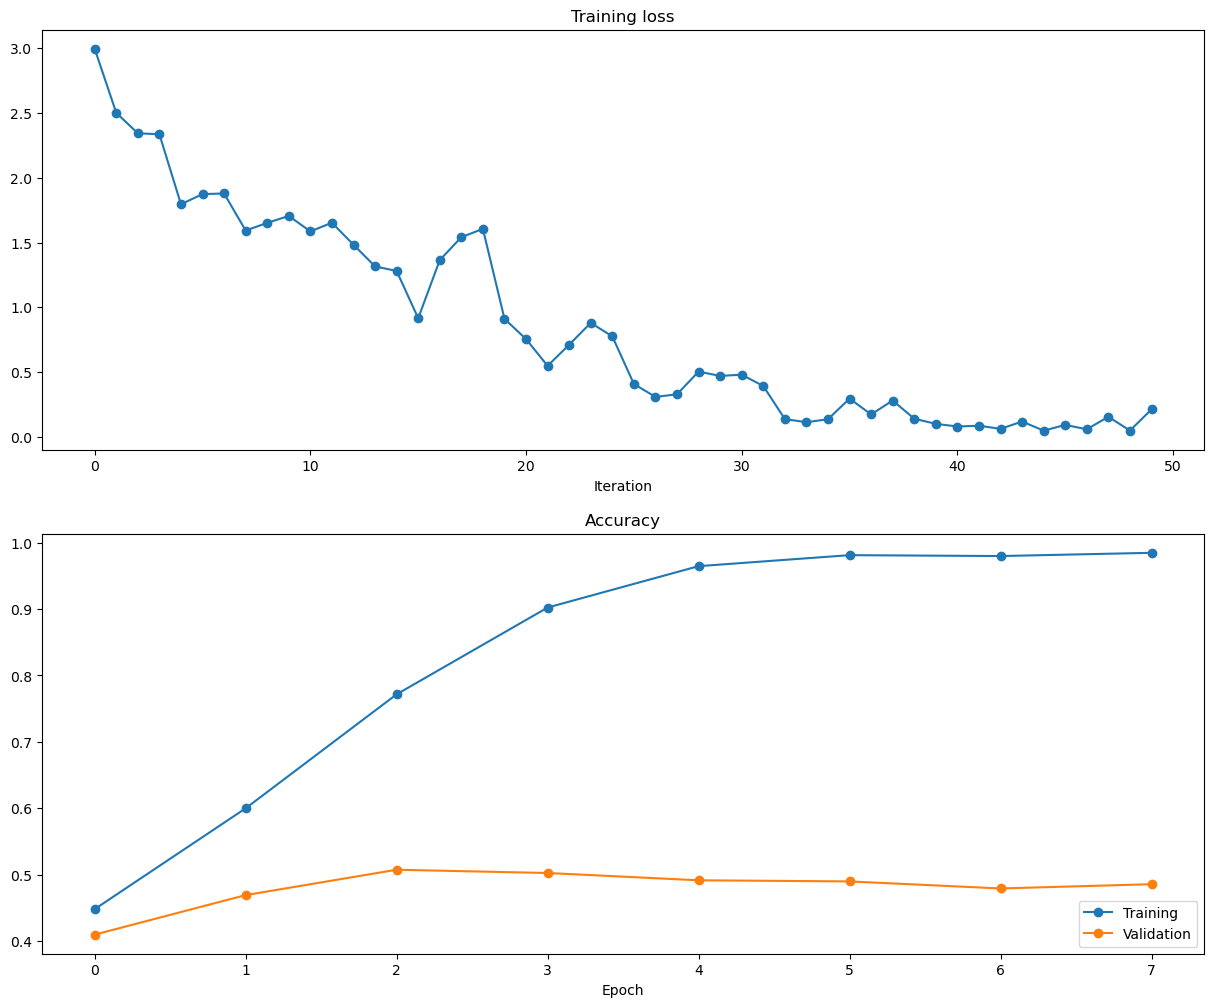

In [67]:
%reload_ext autoreload

opt_params, loss_hist, train_acc_hist, val_acc_hist = results

# Plot the learning curves
plt.subplot(2, 1, 1)
plt.title('Training loss')
loss_hist_ = loss_hist[1::100]  # sparse the curve a bit
plt.plot(loss_hist_, '-o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(train_acc_hist, '-o', label='Training')
plt.plot(val_acc_hist, '-o', label='Validation')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)

plt.show()

### Visualizing Layers [5pts]

An interesting finding from early research in convolutional networks was that the learned convolutions resembled filters used for things like edge detection. Complete the code below to visualize the filters in the first convolutional layer of your best model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


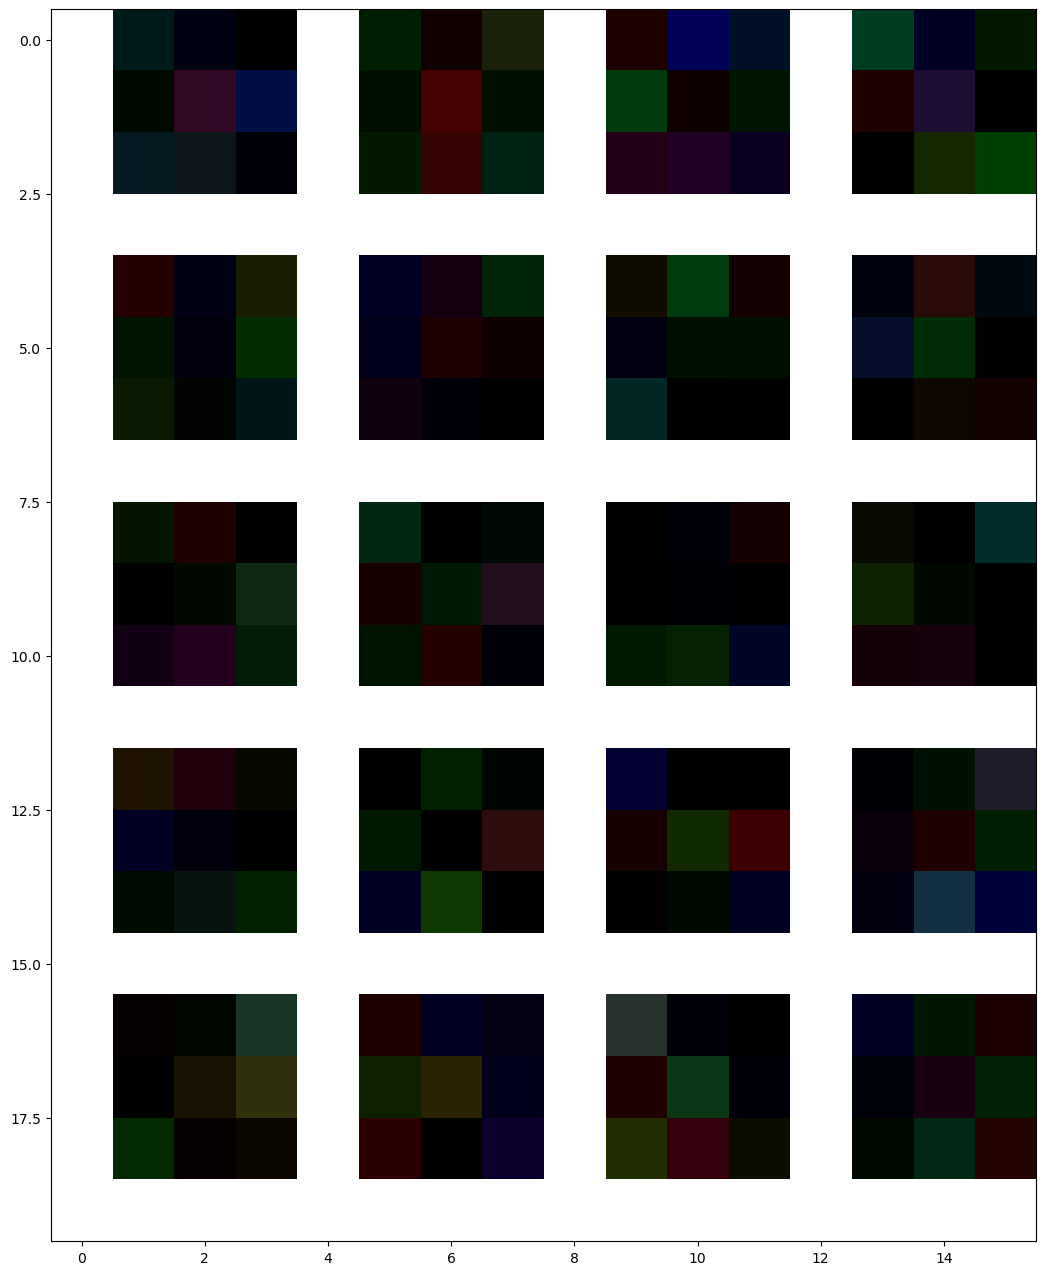

In [81]:
im_array = None
nrows, ncols = None, None

###################################################
# TODO: read the weights in the convolutional     #
# layer and reshape them to a grid of images to   #
# view with matplotlib.                           #
###################################################
my_filter = model.net.get_params("convolution1_w")
nrows = my_filter.shape[-1] // 4
ncols = len(my_filter.shape)
height, weight, input, output = my_filter.shape
my_filter = my_filter.reshape(output, height, weight, input)
update = np.concatenate((my_filter, np.ones((output, 1, weight, input))), axis=1)
intermediate = np.ones((output, update.shape[1], 1, input))
update = np.concatenate((intermediate, update), axis=2)

im_array = update.reshape(nrows, ncols, update.shape[1], update.shape[2], update.shape[3]).\
    swapaxes(1,2).reshape(update.shape[1] * nrows, update.shape[2] * ncols, update.shape[3])
plt.figure(figsize=(16,16))
###################################################
#                END OF YOUR CODE                 #
###################################################

plt.imshow(im_array)

#### Inline Question: Comment below on what kinds of filters you see. Include your response in your submission [5pts]

I noticed that the filters seems to cover more on the right side and middle of the image. Some filters tried to learn patterns from upper right corner, some tried to learn from lower right, a large majority of the rest tried to learn from the center of the image, while the left upper side and corner seemed to be less covered by the filters. Overall, the filters aimed mostly at the right edge, the left lower corner, and the center of the image.

## Extra-Credit: Analysis on Trained Model [5pts]

For extra credit, you can perform some additional analysis of your trained model. Some suggested analyses are:
1. Plot the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of your model's predictions on the test set. Look for trends to see which classes are frequently misclassified as other classes (e.g. are the two vehicle superclasses frequently confused with each other?).
2. Implement [BatchNorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) and analyze how the models train with and without BatchNorm.
3. Introduce some small noise in the labels, and investigate how that affects training and validation accuracy.

You are free to choose any analysis question of interest to you. We will not be providing any starter code for the extra credit. Include your extra-credit analysis as the final section of your report pdf, titled "Extra Credit".

# Submission

Please prepare a PDF document `problem_2_solution.pdf` in the root directory of this repository with all plots and inline answers of your solution. Concretely, the document should contain the following items in strict order:
1. Training loss / accuracy curves for CNN training
2. Visualization of convolutional filters
3. Answers to inline questions about convolutional filters

Note that you still need to submit the jupyter notebook with all generated solutions. We will randomly pick submissions and check that the plots in the PDF and in the notebook are equivalent.